In [1]:
import os
import b3d
import jax.numpy as jnp
import numpy as np
import h5py
import matplotlib.pyplot as plt



In [32]:
# paths for reading physion metadata
physion_assets_path = os.path.join(
    b3d.get_root_path(),
    "assets/physion/",)

stim_name = 'pilot_dominoes_1mid_J025R45_boxroom_0012'

hdf5_file_path = os.path.join(physion_assets_path,
    f"hdf5s/{stim_name}.hdf5",
)

video_file_path = os.path.join(physion_assets_path,
    f"videos/{stim_name}_img.mp4",
)

In [3]:
def compute_angular_velocity(q1, q2, dt):
    return (2 / dt) * np.array([
        q1[0]*q2[1] - q1[1]*q2[0] - q1[2]*q2[3] + q1[3]*q2[2],
        q1[0]*q2[2] + q1[1]*q2[3] - q1[2]*q2[0] - q1[3]*q2[1],
        q1[0]*q2[3] - q1[1]*q2[2] + q1[2]*q2[1] - q1[3]*q2[0]])

In [33]:
fps = b3d.io.utils.load_video_info(video_file_path).fps
delta_t = 1/fps
obj_idx = 2

recorded = []
computed = []
with h5py.File(hdf5_file_path, "r") as f:
    for key in f['frames'].keys():
        ang_vel = jnp.array(f['frames'][key]['objects']['angular_velocities'])
        quaternion_now = jnp.array(f['frames'][key]['objects']['rotations_cam0'])
        # print(ang_vel.shape, quaternion_now.shape)
        if key == '0000':
            continue
        frame_idx = int(key)
        quaternion_last = jnp.array(f['frames'][str(frame_idx-1).zfill(4)]['objects']['rotations_cam0'])
        angular_velocity = compute_angular_velocity(quaternion_last[obj_idx], quaternion_now[obj_idx], delta_t)
        angular_velocity = np.dot(angular_velocity, np.array([[0,0,1],[0,-1,0],[-1,0,0]]))
        recorded.append(ang_vel[obj_idx])
        computed.append(angular_velocity)
        # print("Angular Velocity computed:", angular_velocity)
        # print("Angular Velocity recorded:", ang_vel[obj_idx], '\n')

In [34]:
recorded = np.array(recorded)
computed = np.array(computed)

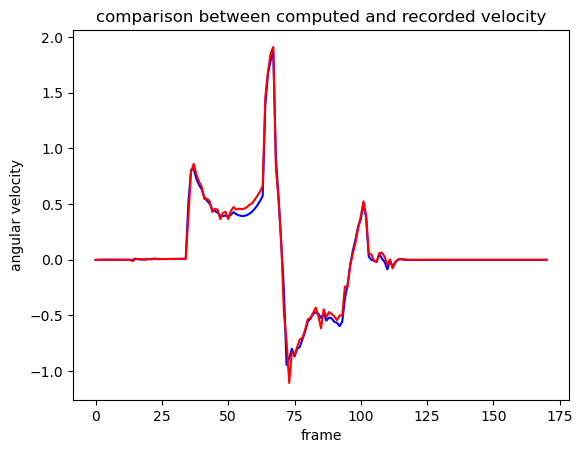

In [37]:
dim = 0

frames = [i for i in range(computed[:,0].shape[0])]

plt.plot(frames, recorded[:,dim], 'blue')
plt.plot(frames, computed[:,dim], 'red')
plt.xlabel("frame")
plt.ylabel("angular velocity")
plt.title('comparison between computed and recorded velocity')
plt.show()
